### Imports

In [4]:
import pickle as pkl
import lxml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import importlib
import time
import traceback
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random
import subprocess
import scipy
import seaborn as sns




from tensorflow.keras.datasets import imdb
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add,ZeroPadding1D, Layer, Lambda
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from pylab import *
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [5]:
tqdm.pandas()

In [6]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

### Helper Functions / Classes

In [7]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

### Data

In [7]:
chunk_size = 100

drugbank_reader = pd.read_csv('../data/intermediate/interactions_preprocessed_OG.csv', chunksize = chunk_size, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


print ("Reading data - chunk size : " + str(chunk_size) )
start = time.time()
drugbank = drugbank_reader.__next__()
end = time.time()
print ("Data read complete : " + str(end - start) + "s")



Reading data - chunk size : 100
Data read complete : 1.05830717086792s


### Training On Drug - Gene - Gene Interaction

Triplet - [Anchor = Drug, Positive = Gene, Negative = Gene]

In [ ]:
drugbank

In [6]:
duplicates_dict = {}

for drugbank in tqdm(drugbank_reader):
    
    for i in range(len(drugbank)):
        
        drug_id = drugbank['drug_id'].values[i]
        gene_id = drugbank['gene_id'].values[i]
        binding = str(drugbank['Y'].values[i])
        
        try:
            duplicates_dict[drug_id + "-" + gene_id + "-" + binding] = duplicates_dict[drug_id + "-" + gene_id + "-" + binding] + 1
        except: 
            duplicates_dict[drug_id + "-" + gene_id + "-" + binding] = 1

In [8]:
duplicates_dict = sorted(duplicates_dict.items(), key = lambda kv : kv[1], reverse = True)

In [16]:
duplicate_count = 0
total = 0
for i in range(len(duplicates_dict)):
    total = total + duplicates_dict[i][-1]
    if duplicates_dict[i][-1] > 1:
        duplicate_count = duplicate_count + 1

In [14]:
duplicate_count

12053

In [17]:
total

42124

In [9]:
drug_dict = {}
drug_id_to_code = {}
gene_id_to_code = {}

for drugbank in tqdm(drugbank_reader):
    
    for i in range(len(drugbank)):
        
        drug_id = drugbank['drug_id'].values[i]
        gene_id = drugbank['gene_id'].values[i]
        binding = drugbank['Y'].values[i]
        gene_code = drugbank['target_gene_encoded_padded'].values[i]
        drug_code = drugbank['drug_fingerprint_encoded_padded'].values[i]
        
        try:
            drug_dict[drug_id]
        except:
            drug_dict[drug_id] = {}
            
        try:
            drug_dict[drug_id][binding].append(gene_id)
        except:
            drug_dict[drug_id][binding] = [gene_id]
            
        drug_id_to_code[drug_id] = drug_code
        gene_id_to_code[gene_id] = gene_code
            
    
    

#### Sanity Checks?

In [36]:
for drug in drug_dict.keys():
    if 1 in drug_dict[drug].keys() and 0 in drug_dict[drug].keys():
        print (drug_dict[drug])

{1: ['BE0002262', 'BE0002266', 'BE0002265', 'BE0002264', 'BE0000259', 'BE0000391', 'BE0002263', 'BE0000109'], 0: ['BE0001974', 'BE0001974']}
{0: ['BE0001974', 'BE0002423', 'BE0001974', 'BE0002423'], 1: ['BE0000042']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0002340', 'BE0000217']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0000270']}
{1: ['BE0000776'], 0: ['BE0004225', 'BE0001974', 'BE0004224', 'BE0004223', 'BE0004224', 'BE0004225']}
{1: ['BE0001176', 'BE0000876', 'BE0002639', 'BE0000837'], 0: ['BE0001974']}
{1: ['BE0002092', 'BE0001015', 'BE0000953', 'BE0000538', 'BE0002091'], 0: ['BE0001974']}
{1: ['BE0000402'], 0: ['BE0001974']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0000280']}
{1: ['BE0000477'], 0: ['BE0001974', 'BE0001974']}
{0: ['BE0004223', 'BE0004224', 'BE0004225', 'BE0004225', 'BE0004224', 'BE0004223'], 1: ['BE0000919', 'BE0000279']}
{0: ['BE0001974', 'BE0002423', 'BE0002423'], 1: ['BE0000630']}
{0: ['BE0004225', 'BE0004224', 'BE0004225', 'BE0004224', 'BE0004223'], 1: ['BE0000279']}

{0: ['BE0001974'], 1: ['BE0001072']}
{1: ['BE0001072'], 0: ['BE0001974']}
{1: ['BE0000916'], 0: ['BE0001974']}
{1: ['BE0000916'], 0: ['BE0001974']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0000923']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0001594']}
{0: ['BE0002423', 'BE0001974', 'BE0002423', 'BE0003348', 'BE0001974'], 1: ['BE0000865']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0000991']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0002050']}
{1: ['BE0000916'], 0: ['BE0001974', 'BE0001974']}
{0: ['BE0004225', 'BE0002423', 'BE0004224', 'BE0004223', 'BE0001974', 'BE0004223', 'BE0004224', 'BE0002423', 'BE0001974'], 1: ['BE0002718']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0004096']}
{1: ['BE0001594'], 0: ['BE0001974']}
{0: ['BE0001974', 'BE0001974'], 1: ['BE0001594']}
{0: ['BE0004223', 'BE0001974', 'BE0002495', 'BE0004224', 'BE0001974', 'BE0001940', 'BE0004225', 'BE0001940', 'BE0002495', 'BE0004224', 'BE0003348'], 1: ['BE0000966']}
{1: ['BE0000854'], 0: ['BE0001974', 'BE0001974']}
{1: ['BE0004105'],

In [10]:
usable_drugs = []

print ("Total Number Of Drugs : " + str(len(drug_dict.keys())))

for drug in drug_dict.keys():
    if 1 in drug_dict[drug].keys() and 0 in drug_dict[drug].keys():
        usable_drugs.append(drug)
        
print ("Total Number Of Usable Drugs (Drugs That Have Data On Both Binding & No Binding) : " + str(len(usable_drugs)))

Total Number Of Drugs : 6195
Total Number Of Usable Drugs (Drugs That Have Data On Both Binding & No Binding) : 2200


#### Create Training Data

In [11]:
triplet_sets = []

for drug in usable_drugs: 
    
    positive_genes = list(set(drug_dict[drug][1]))
    negative_genes = list(set(drug_dict[drug][0]))
    
    for p in range(len(positive_genes)):
        for n in range(len(negative_genes)):
            triplet_sets.append([drug, positive_genes[p], negative_genes[n]])

In [12]:
print ("Number Of Triplets : " + str(len(triplet_sets)))

Number Of Triplets : 20214


#### Sanity Checks 

In [36]:
drug_dict[usable_drugs[0]]

{1: ['BE0002262',
  'BE0002266',
  'BE0002265',
  'BE0002264',
  'BE0000259',
  'BE0000391',
  'BE0002263',
  'BE0000109'],
 0: ['BE0001974', 'BE0001974']}

In [37]:
triplet_sets[:20]

[['DB00141', 'BE0000391', 'BE0001974'],
 ['DB00141', 'BE0002265', 'BE0001974'],
 ['DB00141', 'BE0002263', 'BE0001974'],
 ['DB00141', 'BE0002262', 'BE0001974'],
 ['DB00141', 'BE0000109', 'BE0001974'],
 ['DB00141', 'BE0002264', 'BE0001974'],
 ['DB00141', 'BE0002266', 'BE0001974'],
 ['DB00141', 'BE0000259', 'BE0001974'],
 ['DB00147', 'BE0000042', 'BE0002423'],
 ['DB00147', 'BE0000042', 'BE0001974'],
 ['DB00181', 'BE0000217', 'BE0001974'],
 ['DB00181', 'BE0002340', 'BE0001974'],
 ['DB00212', 'BE0000270', 'BE0001974'],
 ['DB00282', 'BE0000776', 'BE0001974'],
 ['DB00282', 'BE0000776', 'BE0004225'],
 ['DB00282', 'BE0000776', 'BE0004224'],
 ['DB00282', 'BE0000776', 'BE0004223'],
 ['DB00284', 'BE0000876', 'BE0001974'],
 ['DB00284', 'BE0001176', 'BE0001974'],
 ['DB00284', 'BE0002639', 'BE0001974']]

In [13]:
print ("Length Of Drug Codes : " + str(len(drug_id_to_code['DB00284'])))
print ("Length Of Gene Codes : " + str(len(gene_id_to_code['BE0000042'])))
print ("Padding Required To Equalise Drug Length : " + str(len(gene_id_to_code['BE0000042']) - len(drug_id_to_code['DB00284'])))

Length Of Drug Codes : 9501
Length Of Gene Codes : 21222
Padding Required To Equalise Drug Length : 11721


In [14]:
pad_length = int(len(gene_id_to_code['BE0000042']) - len(drug_id_to_code['DB00284'])) // 2

In [15]:
pad_length

5860

In [16]:
train_set = []


for triplet in tqdm(triplet_sets):
    
    # Add One To Ensure '0' Is The Pad Value
    drug = drug_id_to_code[triplet[0]].astype(np.float) + 1
    p_gene = gene_id_to_code[triplet[1]].astype(np.float) + 1
    n_gene = gene_id_to_code[triplet[2]].astype(np.float) + 1

    
    # Pad Drugs 
    
    # Left Pad
    drug = np.hstack((np.zeros(pad_length,), drug))
    
    # Right Pad
    drug = np.hstack((drug, np.zeros(pad_length + 1,)))
    
    assert drug.shape == p_gene.shape
    
    
    drug = np.expand_dims(drug, axis = 0)
    drug = np.expand_dims(drug, axis = -1)
    
    p_gene = np.expand_dims(p_gene, axis = 0)
    p_gene = np.expand_dims(p_gene, axis = -1)
    
    n_gene = np.expand_dims(n_gene, axis = 0)
    n_gene = np.expand_dims(n_gene, axis = -1)
    
    train_set.append([drug, p_gene, n_gene])
    

In [14]:
train_set_split = train_set[:-1982]
validation_set_split = train_set[-1982:]

In [21]:
train_set_split, validation_set_split = train_test_split(np.array(train_set))

In [22]:
train_set_split.shape

(15160, 3, 1, 21222, 1)

In [25]:
validation_set_split.shape

(5054, 3, 1, 21222, 1)

### [Old] Training On Gene Gene Interaction 

In [8]:
compressed_db = drugbank[drugbank['Y'] == 1][['drug_id', 'gene_id']]

In [9]:
drug_dict = {}
gene_dict = {}
gene_id_code = {}
gene_id_encoding = {}

for drugbank in tqdm(drugbank_reader):
    
    compressed_db = drugbank[drugbank['Y'] == 1][['drug_id', 'gene_id']]
    
    for i in range(len(compressed_db)):
        
        try:
            drug = compressed_db['drug_id'].values[i]
            gene = compressed_db['gene_id'].values[i]

            try:
                drug_dict[drug].add(gene)
            except: 
                drug_dict[drug] = set()
                drug_dict[drug].add(gene)

            try:
                gene_dict[gene].add(drug)
            except: 
                gene_dict[gene] = set()
                gene_dict[gene].add(drug)
                
             
            gene_id_code[gene] = drugbank[drugbank['gene_id'] == gene]['target_gene_encoded_len'].values[0]
            gene_id_encoding[gene] = drugbank[drugbank['gene_id'] == gene]['target_gene_encoded_padded'].values[0]
        
        except Exception as e: 
            print ("Exception : " + str(e))
            traceback.print_exc()
            continue

In [10]:
print ("Number Of Unique Drugs : " + str(len(drug_dict.keys())))
print ("Number Of Unique Genes : " + str(len(gene_dict.keys())))

Number Of Unique Drugs : 6215
Number Of Unique Genes : 3774


In [11]:
drug_to_gene_count = np.zeros((len(drug_dict.keys()), 2))
gene_to_drug_count = np.zeros((len(gene_dict.keys()), 2))

In [12]:
drug_keys = list(drug_dict.keys())
gene_keys = list(gene_dict.keys())

for d in range(len(drug_keys)):
    drug_to_gene_count[d][0] = d
    drug_to_gene_count[d][1] = len(drug_dict[drug_keys[d]])
drug_to_gene_count = pd.DataFrame(drug_to_gene_count)
drug_to_gene_count.columns = ['Drug Index', 'Number Of Genes']
    
for g in range(len(gene_keys)):
    gene_to_drug_count[g][0] = g
    gene_to_drug_count[g][1] = len(gene_dict[gene_keys[g]])
gene_to_drug_count = pd.DataFrame(gene_to_drug_count)
gene_to_drug_count.columns = ['Gene Index', 'Number Of Drugs']

In [13]:
percentile_list = [1, 25, 50, 75, 99]
print ("Percentile Split Of Drug -> Gene Interaction")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(drug_to_gene_count['Number Of Genes'], p)) + " Genes")
print ("") 
print ("Percentile Split Of Gene -> Drug Interaction")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(gene_to_drug_count['Number Of Drugs'], p)) + " Drugs")

Percentile Split Of Drug -> Gene Interaction
p1 : 1.0 Genes
p25 : 1.0 Genes
p50 : 1.0 Genes
p75 : 2.0 Genes
p99 : 19.0 Genes

Percentile Split Of Gene -> Drug Interaction
p1 : 1.0 Drugs
p25 : 1.0 Drugs
p50 : 2.0 Drugs
p75 : 3.0 Drugs
p99 : 43.0 Drugs


#### Build Lists Of Similar Genes

<b>Method 1 : </b>

Randomly Sample Genes To Build Lists Of Similar Genes

This will contain genes overlapping multiple drugs. We could run this multiple times and produce multiple
datasets to train the network on.

In [156]:
number_of_genes = len(gene_dict.keys())
list_of_genes = []
genes_considered = set()

for i in range(1000):
    
    # Select A Random Gene Not Yet Selected
    count = 0
    break_flag = 0
    while gene in genes_considered:
        gene = gene_keys[np.random.randint(number_of_genes)]
        count = count + 1 
        # All Genes Have Been Considered
        if count == len(gene_dict.keys()):
            break_flag = 1
            break
    
    if break_flag == 1: 
        break

    similar_genes = []
    
    # For Each Drug That Works On This Gene
    for drug in gene_dict[gene]:
        
        # Get Other Genes Affected By Drug
        for other_gene in drug_dict[drug]:
            
            # Check If This Gene Already Belongs To Another Group
            if other_gene not in genes_considered:
                genes_considered.add(other_gene)
                similar_genes.append(other_gene)
            else: 
                continue
    
    list_of_genes.append(similar_genes)         


gene_data_distribution = []
gene_train_set = []
min_threshold = 2
for l in list_of_genes: 
    if len(l) > 2:
        gene_train_set.append(l)
        gene_data_distribution.append(len(l))
        
print ("Number Of Similar Gene Lists With Length > " + str(min_threshold) + " : " + str(len(gene_train_set)))
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(gene_data_distribution, p)) + " Similar Genes")
print ("")    

Number Of Similar Gene Lists With Length > 2 : 81
p1 : 3.0 Similar Genes
p25 : 3.0 Similar Genes
p50 : 5.0 Similar Genes
p75 : 13.0 Similar Genes
p99 : 694.6000000000009 Similar Genes



<b>Method 2 : </b>

Pick out genes which are affected only by one drug. Then pick out other genes which are also affected 
by the same drug. 

In doing so, we ensure there is no overlap in similar genes across drugs.

In [14]:
list_of_genes = []
genes_considered = set()
single_drug_gene = []
gene_repeat_count = {}

# Find All Genes That Are Affected Only By ONE Drug 
for gene in gene_dict.keys():
    if len(gene_dict[gene]) == 1:
        single_drug_gene.append(gene)

# For Each Gene
for gene in single_drug_gene:
    
    # Skip Gene If It's Already Part Of A Similar Set
    if gene not in genes_considered: 
        
        genes_considered.add(gene)
        similar_genes = []

        # Find The Drug That Affects It
        drug = list(gene_dict[gene])[0]


        # Find Other Genes This Drug Affects And Add It To Similar Genes
        for other_gene in drug_dict[drug]:
            if other_gene not in genes_considered:
                genes_considered.add(other_gene)
                similar_genes.append(other_gene)
                try:
                    gene_repeat_count[other_gene] = gene_repeat_count[other_gene] + 1
                except: 
                    gene_repeat_count[other_gene] = 1

        list_of_genes.append(similar_genes)
    
    else: 
        continue

gene_data_distribution = []
gene_train_set = []
min_threshold = 2
for l in list_of_genes: 
    if len(l) > min_threshold:
        gene_train_set.append(l)
        gene_data_distribution.append(len(l))
        
print ("Number Of Similar Gene Lists With Length > " + str(min_threshold) + " : " + str(len(gene_train_set)))
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(gene_data_distribution, p)) + " Similar Genes")
print ("")    

Number Of Similar Gene Lists With Length > 2 : 223
p1 : 3.0 Similar Genes
p25 : 4.0 Similar Genes
p50 : 6.0 Similar Genes
p75 : 10.0 Similar Genes
p99 : 54.24000000000001 Similar Genes



In [39]:
deviation_list = []
for gene_l in gene_train_set:
    length_list = []
    for gene in gene_l:
        length_list.append(gene_id_code[gene])
    deviation_list.append(np.std(length_list))

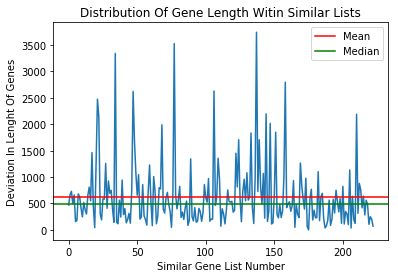

In [40]:
plt.plot(deviation_list)
plt.axhline(np.mean(deviation_list), color = 'r', label = 'Mean')
plt.axhline(np.median(deviation_list), color = 'g', label = 'Median')
plt.xlabel('Similar Gene List Number')
plt.ylabel('Deviation In Lenght Of Genes')
plt.title("Distribution Of Gene Length Witin Similar Lists")
plt.legend()
plt.show()

##### Construct Training Sets 
Select Three Genes - An Anchor Gene, a Positive Gene and a Negative Gene

In [16]:
training_data_start = time.time()
gene_triplet_sanity_check = []
gene_triplet_training_data = []

for similar_list in gene_train_set: 
    
    anchor_gene = similar_list[0]
    for gene in range(1, len(similar_list)):
        positive_gene = similar_list[gene]
        
        random_list = gene_train_set[np.random.randint(0, len(gene_train_set))]
        while similar_list == random_list:
            random_list = gene_train_set[np.random.randint(0, len(gene_train_set))]
            
        negative_gene = np.random.choice(random_list)
        
        anchor_encoding = np.expand_dims(gene_id_encoding[anchor_gene], axis = 0).astype('float64')
        positive_encoding = np.expand_dims(gene_id_encoding[positive_gene], axis = 0).astype('float64')
        negative_encoding = np.expand_dims(gene_id_encoding[negative_gene], axis = 0).astype('float64')
        
        anchor_encoding = np.expand_dims(anchor_encoding, axis = -1)
        positive_encoding = np.expand_dims(positive_encoding, axis = -1)
        negative_encoding = np.expand_dims(negative_encoding, axis = -1)
        
        gene_triplet_training_data.append([anchor_encoding, positive_encoding, negative_encoding])
        gene_triplet_sanity_check.append([anchor_gene, positive_gene, negative_gene])
            
training_data_end = time.time()
print ("Time To Build Training Data : " + str(training_data_end - training_data_start))

Time To Build Training Data : 142.79984307289124


In [17]:
def get_training_data(gene_train_set):
    
    training_data_start = time.time()
    gene_triplet_training_data = []

    for similar_list in gene_train_set: 

        anchor_gene = similar_list[0]
        for gene in range(1, len(similar_list)):
            positive_gene = similar_list[gene]

            random_list = gene_train_set[np.random.randint(0, len(gene_train_set))]
            while similar_list == random_list:
                random_list = gene_train_set[np.random.randint(0, len(gene_train_set))]

            negative_gene = np.random.choice(random_list)

            anchor_encoding = np.expand_dims(gene_id_encoding[anchor_gene], axis = 0).astype('float64')
            positive_encoding = np.expand_dims(gene_id_encoding[positive_gene], axis = 0).astype('float64')
            negative_encoding = np.expand_dims(gene_id_encoding[negative_gene], axis = 0).astype('float64')

            anchor_encoding = np.expand_dims(anchor_encoding, axis = -1)
            positive_encoding = np.expand_dims(positive_encoding, axis = -1)
            negative_encoding = np.expand_dims(negative_encoding, axis = -1)

            gene_triplet_training_data.append([anchor_encoding, positive_encoding, negative_encoding])

    training_data_end = time.time()
    print ("Time To Build Training Data : " + str(training_data_end - training_data_start))
    
    return gene_triplet_training_data

#### Build List Of Similar Drugs

Pick out drugs which work only on one gene. Then pick out other drugs which also work on the same gene.

In doing so, we ensure there is no overlap in similar drugs across genes.

In [162]:
list_of_drugs = []
drugs_considered = set()
single_gene_drug = []

# Find All Drugs That Work Only On ONE Gene
for drug in drug_dict.keys():
    if len(drug_dict[drug]) == 1:
        single_gene_drug.append(drug)
        
# For Each Drug
for drug in single_gene_drug:
    
    # Skip Drug If It's Already Part Of A Similar Set
    if drug not in drugs_considered: 
        
        drugs_considered.add(drug)
        similar_drugs = []

        # Find The Gene That The Drug Works On
        gene = list(drug_dict[drug])[0]


        # Find Other Drugs That Work On This Gene
        for other_drug in gene_dict[gene]:
            similar_drugs.append(other_drug)
            drugs_considered.add(other_drug)

        list_of_drugs.append(similar_drugs)
    
    else: 
        continue
        
drug_data_distribution = []
drug_train_set = []
min_threshold = 2
for l in list_of_drugs: 
    if len(l) > min_threshold:
        drug_train_set.append(l)
        drug_data_distribution.append(len(l))
        
print ("Number Of Similar Drug Lists With Lenght > " + str(min_threshold) + " : " + str(len(drug_train_set)))
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(drug_data_distribution, p)) + " Similar Drugs")
print ("")   

Number Of Similar Drug Lists With Lenght > 2 : 291
p1 : 3.0 Similar Drugs
p25 : 7.0 Similar Drugs
p50 : 14.0 Similar Drugs
p75 : 27.5 Similar Drugs
p99 : 153.30000000000007 Similar Drugs



### Siamese Network

#### Define Convolutional Model 

In [47]:
def conv_network(input_shape = (21222, 1), output_shape = 256):
    
    X_input = Input(input_shape, name = "Input_Layer")
    
    # Convolution Block 1
    X = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB1_Conv_1")(X_input)
    X = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB1_Conv_2")(X)
    X = BatchNormalization(name = "CB1_BN_1")(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 256, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB2_Conv_1")(X)
    X = Conv1D(filters = 256, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB2_Conv_2")(X)
    X = BatchNormalization(name = "CB2_BN_1")(X)
    X = AveragePooling1D(name = "CB2_AvgPool_1")(X)
    # Test Drop Out
    # X = Dropout(0.4)(X)

    # Convolution Block 3
    X = Conv1D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB3_Conv_1")(X)
    X = Conv1D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB3_Conv_2")(X)
    X = Conv1D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB3_Conv_3")(X)
    X = BatchNormalization(name = "CB3_BN_1")(X)
    # Test Drop Out
    # X = Dropout(0.5)(X)
    
    # Convolution Block 4
    X = Conv1D(filters = 512, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB4_Conv_1")(X)
    X = Conv1D(filters = 512, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB4_Conv_2")(X)
    X = Conv1D(filters = 512, kernel_size = 4, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB4_Conv_3")(X)
    X = BatchNormalization(name = "CB4_BN_1")(X)
    
    # Flatten
    X = Flatten(name = "Flatten_Layer")(X)
    X = Dense(512, activation = 'relu', kernel_initializer = 'he_uniform', name = "Dense_Layer_1")(X)
    X = Dense(256, activation = 'relu', kernel_initializer = 'he_uniform', name = "Dense_Layer_2")(X)
    X = Dense(output_shape, activation = None, name = "Final_Dense_Layer")(X)
    
    # Normalise Values
    X = Lambda(lambda x: K.l2_normalize(x, axis = -1))(X)
    
    return Model(inputs = X_input, outputs = X)

In [26]:
def conv_network_2(input_shape = (21222, 1), output_shape = 256):
    
    X_input = Input(input_shape, name = "Input_Layer")
    
    # Convolution Block 1
    X = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB1_Conv_1")(X_input)
    X = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB1_Conv_2")(X)
    X = BatchNormalization(name = "CB1_BN_1")(X)
    X = AveragePooling1D(name = "CB1_AvgPool_1")(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB2_Conv_1")(X)
    X = Conv1D(filters = 128, kernel_size = 8, strides = 2, activation = 'relu', kernel_initializer = 'he_uniform', name = "CB2_Conv_2")(X)
    X = BatchNormalization(name = "CB2_BN_1")(X)
    X = AveragePooling1D(name = "CB2_AvgPool_1")(X)
    # Test Drop Out
    # X = Dropout(0.4)(X)
    
    # Flatten
    X = Flatten(name = "Flatten_Layer")(X)
    X = Dense(256, activation = 'relu', kernel_initializer = 'he_uniform', name = "Dense_Layer_1")(X)
    X = Dense(256, activation = 'relu', kernel_initializer = 'he_uniform', name = "Dense_Layer_2")(X)
    X = Dense(output_shape, activation = None, name = "Final_Dense_Layer")(X)
    
    # Normalise Values
    X = Lambda(lambda x: K.l2_normalize(x, axis = -1))(X)
    
    return Model(inputs = X_input, outputs = X)

In [27]:
def conv_network_3(input_shape = (21222, 1), output_shape = 128):
    
    X_input = Input(input_shape, name = "Input_Layer")
    
    # Convolution Block 1
    X = Conv1D(filters = 256, kernel_size = 8, strides = 2, activation = 'relu')(X_input)
    X = Conv1D(filters = 256, kernel_size = 8, strides = 2, activation = 'relu')(X)
    X = BatchNormalization(name = "CB1_BN_1")(X)
    X = AveragePooling1D()(X)
    X = Dropout(0.5)(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(X)
    X = Conv1D(filters = 64, kernel_size = 8, strides = 2, activation = 'relu')(X)
    X = BatchNormalization(name = "CB2_BN_1")(X)
    # Test Drop Out
    X = Dropout(0.5)(X)
    
    # Flatten
    X = Flatten(name = "Flatten_Layer")(X)
    X = Dense(128, activation = 'relu', name = "Dense_Layer_1")(X)
    X = Dense(output_shape, activation = None, name = "Final_Dense_Layer")(X)
    
    # Normalise Values
    X = Lambda(lambda x: K.l2_normalize(x, axis = -1))(X)
    
    
    return Model(inputs = X_input, outputs = X)

In [28]:
conv_model = conv_network_3()

#### Define Triplet Loss

In [29]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor - positive), axis = -1)
        n_dist = K.sum(K.square(anchor - negative), axis = -1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis = 0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

#### Overall Model

In [30]:
def siamese_model(input_shape, conv_model, margin = 0.5):
    
    # Three Input Genes
    anchor_gene = Input(input_shape, name = "Anchor_Gene")
    positive_gene = Input(input_shape, name = "Positive_Gene")
    negative_gene = Input(input_shape, name = "Negative_Gene") 
    
    # Generate Encodings 
    encoded_a = conv_model(anchor_gene)
    encoded_p = conv_model(positive_gene)
    encoded_n = conv_model(negative_gene)
    
    # Compute Triplet Loss
    loss_layer = TripletLossLayer(alpha = margin, name = 'Triplet_Loss_Layer')([encoded_a, encoded_p, encoded_n])
    
    model = Model(inputs = [anchor_gene, positive_gene, negative_gene], outputs = loss_layer)
    
    return model

In [54]:
siamese_network = siamese_model(input_shape = (21222, 1), conv_model = conv_model)

In [55]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     (None, 21222, 1)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10608, 256)        2304      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5301, 256)         524544    
_________________________________________________________________
CB1_BN_1 (BatchNormalization (None, 5301, 256)         1024      
_________________________________________________________________
average_pooling1d (AveragePo (None, 2650, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2650, 256)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1322, 64)          131136    
__________

In [56]:
siamese_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Gene (InputLayer)        (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
Positive_Gene (InputLayer)      (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
Negative_Gene (InputLayer)      (None, 21222, 1)     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          6099072     Anchor_Gene[0][0]                
                                                                 Positive_Gene[0][0]              
          

In [65]:
optimizer = Adam(lr = 0.0000005)
siamese_network.compile(loss = None, optimizer = optimizer)

#### Train

Epoch : 0 | Triplet : 0 | Triplet Loss : 0.0 | Average Loss : 0.0
Epoch : 0 | Triplet : 500 | Triplet Loss : 0.7264302 | Average Loss : 0.4115897
Epoch : 0 | Triplet : 1000 | Triplet Loss : 0.46428108 | Average Loss : 0.41422206
Epoch : 0 | Triplet : 1500 | Triplet Loss : 0.85842896 | Average Loss : 0.41556948
Epoch : 0 | Triplet : 2000 | Triplet Loss : 0.53323734 | Average Loss : 0.4123608
Epoch : 0 | Triplet : 2500 | Triplet Loss : 0.9535153 | Average Loss : 0.41623902
Epoch : 0 | Triplet : 3000 | Triplet Loss : 0.3031081 | Average Loss : 0.41616714
Epoch : 0 | Triplet : 3500 | Triplet Loss : 0.72969675 | Average Loss : 0.412161
Epoch : 0 | Triplet : 4000 | Triplet Loss : 0.36709654 | Average Loss : 0.41107735
Epoch : 0 | Triplet : 4500 | Triplet Loss : 0.0 | Average Loss : 0.41083738
Epoch : 0 | Triplet : 5000 | Triplet Loss : 0.0 | Average Loss : 0.40955383
Epoch : 0 | Triplet : 5500 | Triplet Loss : 0.68877935 | Average Loss : 0.41025335
Epoch : 0 | Triplet : 6000 | Triplet Loss :


Euclidean Distances


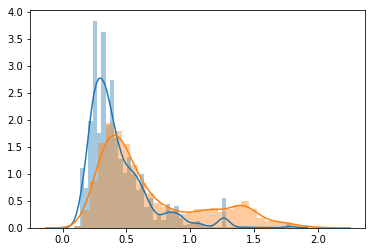

Cosine Distances


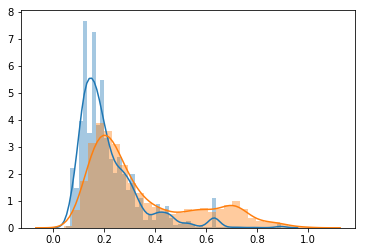

Validation Loss : 0.33948004


IndexError: list index out of range

In [66]:
epoch = 15
print_frequency = 500
losses = []
val_loss = []

train_start = time.time()

for e in range(epoch):
    
    epoch_loss = []
    epoch_start = time.time()
    for data in range(len(train_set_split)):
        
        triplets = list(train_set_split[data])
        loss = siamese_network.train_on_batch(triplets, None)
        epoch_loss.append(loss)
        
        if data % print_frequency == 0:
            print ("Epoch : " + str(e) + " | Triplet : " + str(data) + " | Triplet Loss : " + str(loss) + " | Average Loss : " + str(np.mean(epoch_loss)))
    
    epoch_end = time.time()
    
    # Get Validation Score
    v_loss = validate_model(validation_set_split)
    val_loss.append(v_loss)

    # Check if this is the best score yet and save model
    try:
        if v_loss < val_loss[-2]:
            conv_model.save_weights('../data/models/Siamese_Conv_Model_DGG.model')
            siamese_network.save_weights('../data/models/Siamese_Network_DGG.model')
    except: 
        None
    
    print ("Epoch Time : " + str(epoch_end - epoch_start))
    
    losses.append(np.mean(epoch_loss))
train_end = time.time()
print ("Total Time To Train : " + str(train_end - train_start)) 

In [145]:
conv_model.save_weights('../data/models/Siamese_Conv_Model_DGG_25e.model')
siamese_network.save_weights('../data/models/Siamese_Network_DGG_25e.model')

# conv_model.load_weights('../data/models/Siamese_Conv_Model_Normalised_Small_20e.model')
# siamese_network.load_weights('../data/models/Siamese_Network_Normalised_Small_20e.model')



Consider using a TensorFlow optimizer from `tf.train`.


Text(0,0.5,'Loss')

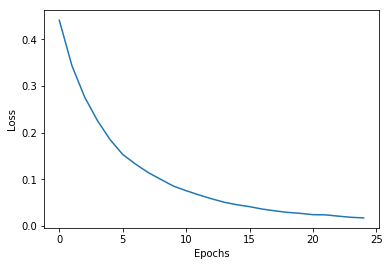

In [ ]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [63]:
def validate_model(input_split):
    
    # Validation
    positive_distances = []
    negative_distances = []
    p_n = []

    positive_distances_cos = []
    negative_distances_cos = []
    p_n_cos = []
    
    loss = []


    for example in tqdm(range(len(input_split))):

        a = input_split[example][0]
        p = input_split[example][1]
        n = input_split[example][2]

        a_embedding = conv_model.predict(a)
        p_embedding = conv_model.predict(p)
        n_embedding = conv_model.predict(n)

        p_dist_euclidean = np.sum(np.square(a_embedding - p_embedding), axis = -1)
        n_dist_euclidean = np.sum(np.square(a_embedding - n_embedding), axis = -1)
        p_n_dist_euclidean = np.sum(np.square(p_embedding - n_embedding), axis = -1)

        p_dist_cos = scipy.spatial.distance.cosine(a_embedding, p_embedding)
        n_dist_cos = scipy.spatial.distance.cosine(a_embedding, n_embedding)
        p_n_dist_cos = scipy.spatial.distance.cosine(p_embedding, n_embedding)

        positive_distances_cos.append(p_dist_cos)
        negative_distances_cos.append(n_dist_cos)
        p_n_cos.append(p_n_dist_cos)

        positive_distances.append(p_dist_euclidean[0])
        negative_distances.append(n_dist_euclidean[0])
        p_n.append(p_n_dist_euclidean[0])

        loss.append(siamese_network.predict(list(input_split[example]))[0])

    print ("Euclidean Distances")
    # Euclidean Distances
    for a in [positive_distances, negative_distances]:
        sns.distplot(a)
    plt.show()

    print ("Cosine Distances")
    # Cosine Distances
    for a in [positive_distances_cos, negative_distances_cos]:
        sns.distplot(a)
    plt.show()
    
    print ("Validation Loss : " + str(np.mean(loss)))
    
    return np.mean(loss)


Euclidean Distances


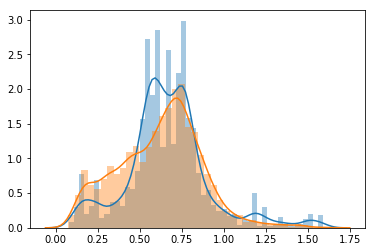

Cosine Distances


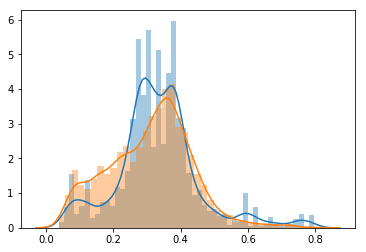

Validation Loss : 0.55440915


In [52]:
validate_model(validation_set_split)


Euclidean Distances


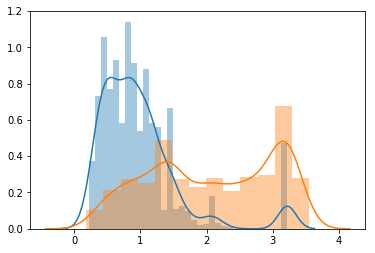

Cosine Distances


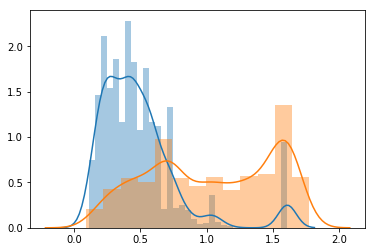

In [ ]:
# Validation
positive_distances = []
negative_distances = []
p_n = []

positive_distances_cos = []
negative_distances_cos = []
p_n_cos = []


for example in tqdm(range(len(validation_set_split))):
    
    a = validation_set_split[example][0]
    p = validation_set_split[example][1]
    n = validation_set_split[example][2]

    a_embedding = conv_model.predict(a)
    p_embedding = conv_model.predict(p)
    n_embedding = conv_model.predict(n)

    p_dist_euclidean = np.sum(np.square(a_embedding - p_embedding), axis = -1)
    n_dist_euclidean = np.sum(np.square(a_embedding - n_embedding), axis = -1)
    p_n_dist_euclidean = np.sum(np.square(p_embedding - n_embedding), axis = -1)
    
    p_dist_cos = scipy.spatial.distance.cosine(a_embedding, p_embedding)
    n_dist_cos = scipy.spatial.distance.cosine(a_embedding, n_embedding)
    p_n_dist_cos = scipy.spatial.distance.cosine(p_embedding, n_embedding)
    
    positive_distances_cos.append(p_dist_cos)
    negative_distances_cos.append(n_dist_cos)
    p_n_cos.append(p_n_dist_cos)
    
    positive_distances.append(p_dist_euclidean[0])
    negative_distances.append(n_dist_euclidean[0])
    p_n.append(p_n_dist_euclidean[0])


print ("Euclidean Distances")
# Model 2
# Euclidean Distances
for a in [positive_distances, negative_distances]:
    sns.distplot(a)
plt.show()
    
print ("Cosine Distances")
# Cosine Distances
for a in [positive_distances_cos, negative_distances_cos]:
    sns.distplot(a)
plt.show()


Euclidean Distances


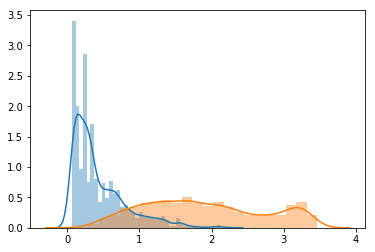

Cosine Distances


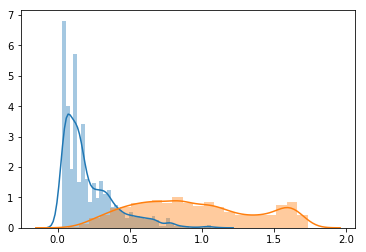

In [ ]:
# Training Data
positive_distances = []
negative_distances = []
p_n = []

positive_distances_cos = []
negative_distances_cos = []
p_n_cos = []


for example in tqdm(range(5000)):
    

    a = train_set_split[example][0]
    p = train_set_split[example][1]
    n = train_set_split[example][2]

    a_embedding = conv_model.predict(a)
    p_embedding = conv_model.predict(p)
    n_embedding = conv_model.predict(n)

    p_dist_euclidean = np.sum(np.square(a_embedding - p_embedding), axis = -1)
    n_dist_euclidean = np.sum(np.square(a_embedding - n_embedding), axis = -1)
    p_n_dist_euclidean = np.sum(np.square(p_embedding - n_embedding), axis = -1)

    p_dist_cos = scipy.spatial.distance.cosine(a_embedding, p_embedding)
    n_dist_cos = scipy.spatial.distance.cosine(a_embedding, n_embedding)
    p_n_dist_cos = scipy.spatial.distance.cosine(p_embedding, n_embedding)

    positive_distances_cos.append(p_dist_cos)
    negative_distances_cos.append(n_dist_cos)
    p_n_cos.append(p_n_dist_cos)

    positive_distances.append(p_dist_euclidean[0])
    negative_distances.append(n_dist_euclidean[0])
    p_n.append(p_n_dist_euclidean[0])


print ("Euclidean Distances")
# Model 2
# Euclidean Distances
for a in [positive_distances, negative_distances]:
    sns.distplot(a)
plt.show()
    
print ("Cosine Distances")
# Cosine Distances
for a in [positive_distances_cos, negative_distances_cos]:
    sns.distplot(a)
plt.show()

Euclidean Distances


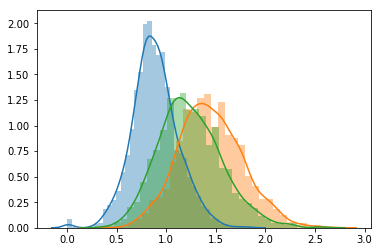

Cosine Distances


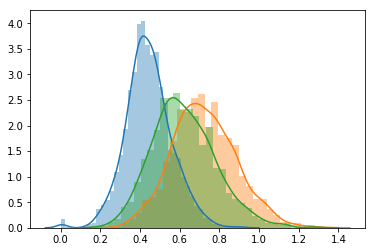

In [236]:
print ("Euclidean Distances")
# Model 3 
# Euclidean Distances
for a in [positive_distances, negative_distances, p_n]:
    sns.distplot(a)
plt.show()
    
print ("Cosine Distances")
# Cosine Distances
for a in [positive_distances_cos, negative_distances_cos, p_n_cos]:
    sns.distplot(a)
plt.show()

Euclidean Distances


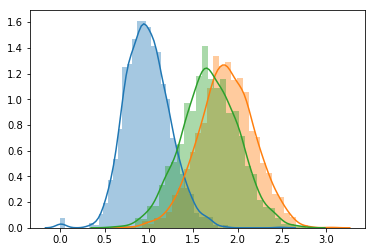

Cosine Distances


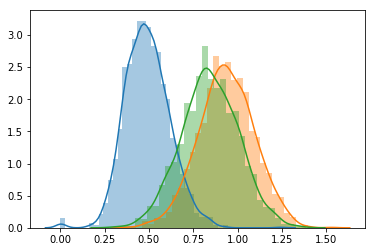

In [212]:
print ("Euclidean Distances")
# Model 3 
# Euclidean Distances
for a in [positive_distances, negative_distances, p_n]:
    sns.distplot(a)
plt.show()
    
print ("Cosine Distances")
# Cosine Distances
for a in [positive_distances_cos, negative_distances_cos, p_n_cos]:
    sns.distplot(a)
plt.show()

In [102]:
print ("Positive Distance Distribution")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(positive_distances, p)))
print ("")   

print ("Negative Distance Distribution")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(negative_distances, p)))
print ("")   

print ("Difference Distribution")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(differences, p)))
print ("")   

Positive Distance Distribution
p1 : 0.28798921823501583
p25 : 0.6270915865898132
p50 : 0.8068949282169342
p75 : 1.0654379725456238
p99 : 1.6997961735725409

Negative Distance Distribution
p1 : 0.648805924654007
p25 : 1.1912773549556732
p50 : 1.4835593104362488
p75 : 1.7922295928001404
p99 : 2.3716224765777603

Difference Distribution
p1 : -0.14970303893089296
p25 : 0.37277379631996155
p50 : 0.6142381131649017
p75 : 0.8691025227308273
p99 : 1.5236237955093401



In [93]:
print ("Positive Distance Distribution")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(positive_distances, p)))
print ("")   

print ("Negative Distance Distribution")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(negative_distances, p)))
print ("")   

print ("Difference Distribution")
for p in percentile_list: 
    print ("p" + str(p) + " : " + str(np.percentile(differences, p)))
print ("")   

Positive Distance Distribution
p1 : 0.40253635615110395
p25 : 0.7462485134601593
p50 : 0.9275108277797699
p75 : 1.1489377617835999
p99 : 1.7713043153285988

Negative Distance Distribution
p1 : 0.9165132832527161
p25 : 1.385314792394638
p50 : 1.6340044736862183
p75 : 1.9053904712200165
p99 : 2.494521417617798

Difference Distribution
p1 : -0.048969300985336306
p25 : 0.44323283433914185
p50 : 0.6572026014328003
p75 : 0.9032202064990997
p99 : 1.6174429440498361



In [104]:
gene_similarity_label = {}
for l in range(len(gene_train_set)): 
    for gene in gene_train_set[l]: 
        gene_similarity_label[gene] = l

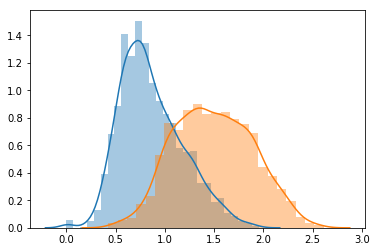

In [120]:

# Euclidean Distances
for a in [positive_distances, negative_distances]:
    sns.distplot(a)

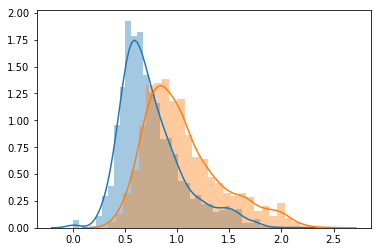

In [198]:
# Model 3 

# Euclidean Distances
for a in [positive_distances, negative_distances]:
    sns.distplot(a)

In [214]:
gene_learned_encodings = np.zeros((len(list(gene_dict.keys())), 64))
gene_label = np.zeros((len(list(gene_dict.keys())), 1))
idx = 0
for gene in tqdm(gene_dict): 
    
    gene_code = np.expand_dims(gene_id_encoding[gene], axis = 0).astype('float64')
    gene_code = np.expand_dims(gene_code, axis = -1)
    gene_learned_encodings[idx, :] = conv_model.predict([gene_code])
    try:
        gene_label[idx, :] = gene_similarity_label[gene]
    except: 
        gene_label[idx, :] = -1
    idx = idx + 1

In [215]:
for i in range(len(gene_label)):
    if gene_label[i] > 3: 
        gene_label[i] = 4

In [216]:
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(gene_learned_encodings)
print("t-SNE Completed In : " + str(time.time() - time_start) + " seconds")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3774 samples in 0.007s...
[t-SNE] Computed neighbors for 3774 samples in 1.630s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3774
[t-SNE] Computed conditional probabilities for sample 2000 / 3774
[t-SNE] Computed conditional probabilities for sample 3000 / 3774
[t-SNE] Computed conditional probabilities for sample 3774 / 3774
[t-SNE] Mean sigma: 0.271910
[t-SNE] KL divergence after 200 iterations with early exaggeration: 81.418541
[t-SNE] Error after 300 iterations: 2.454919
t-SNE Completed In : 46.13510727882385 seconds


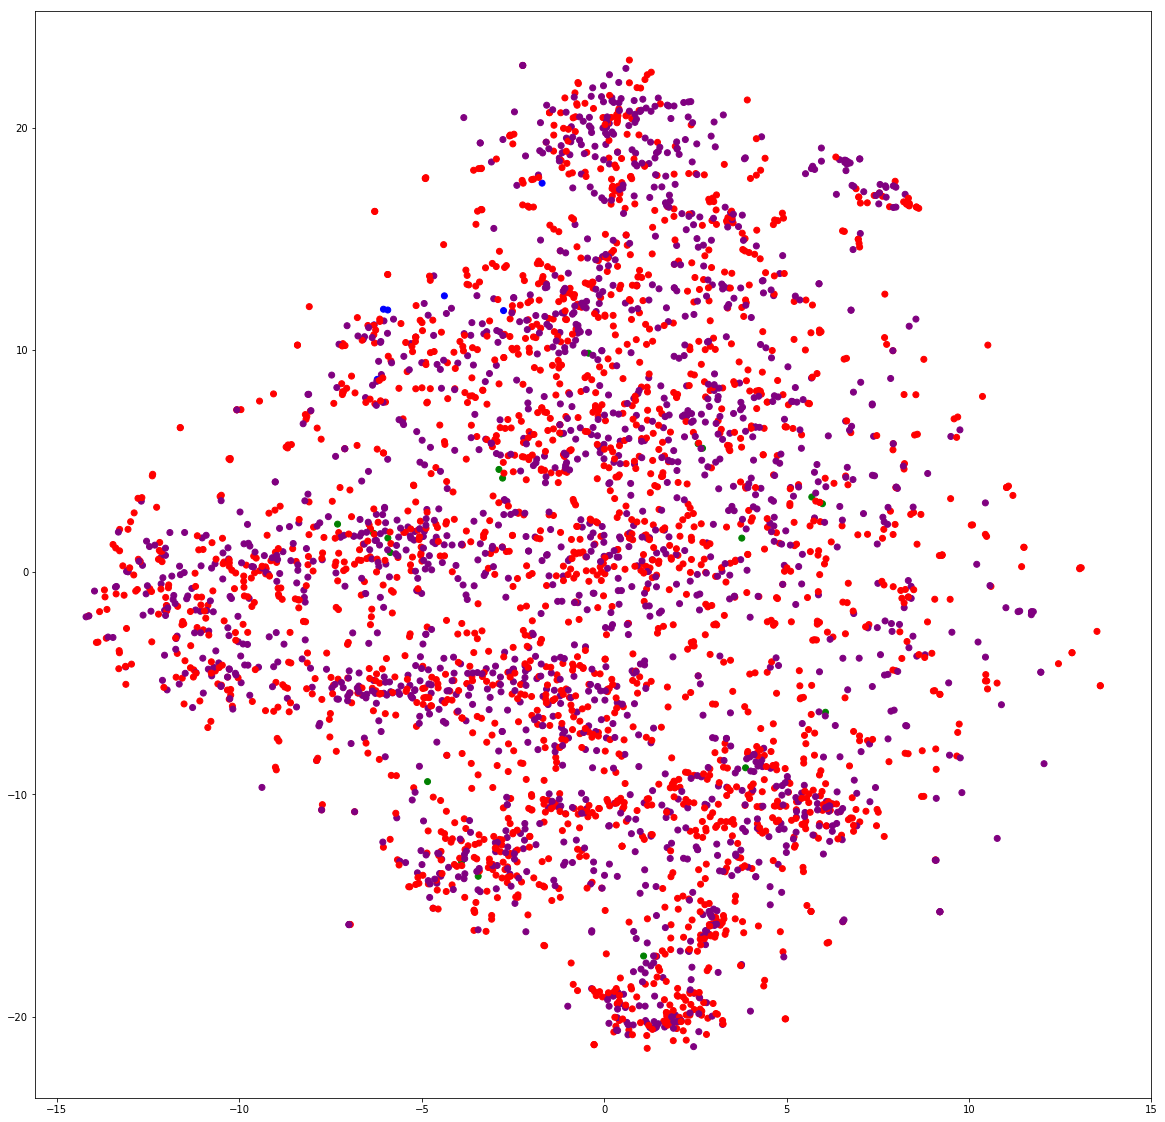

In [217]:
plt.figure(figsize= (20, 20))
colors = ['purple','green','blue','red']
plt.scatter(x = tsne_results[:, 0], y = tsne_results[:, 1], c = gene_label[:, 0], cmap = matplotlib.colors.ListedColormap(colors))
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3774 samples in 0.025s...
[t-SNE] Computed neighbors for 3774 samples in 6.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3774
[t-SNE] Computed conditional probabilities for sample 2000 / 3774
[t-SNE] Computed conditional probabilities for sample 3000 / 3774
[t-SNE] Computed conditional probabilities for sample 3774 / 3774
[t-SNE] Mean sigma: 0.212879
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.197823
[t-SNE] Error after 300 iterations: 2.342543
t-SNE Completed In : 86.32708597183228 seconds


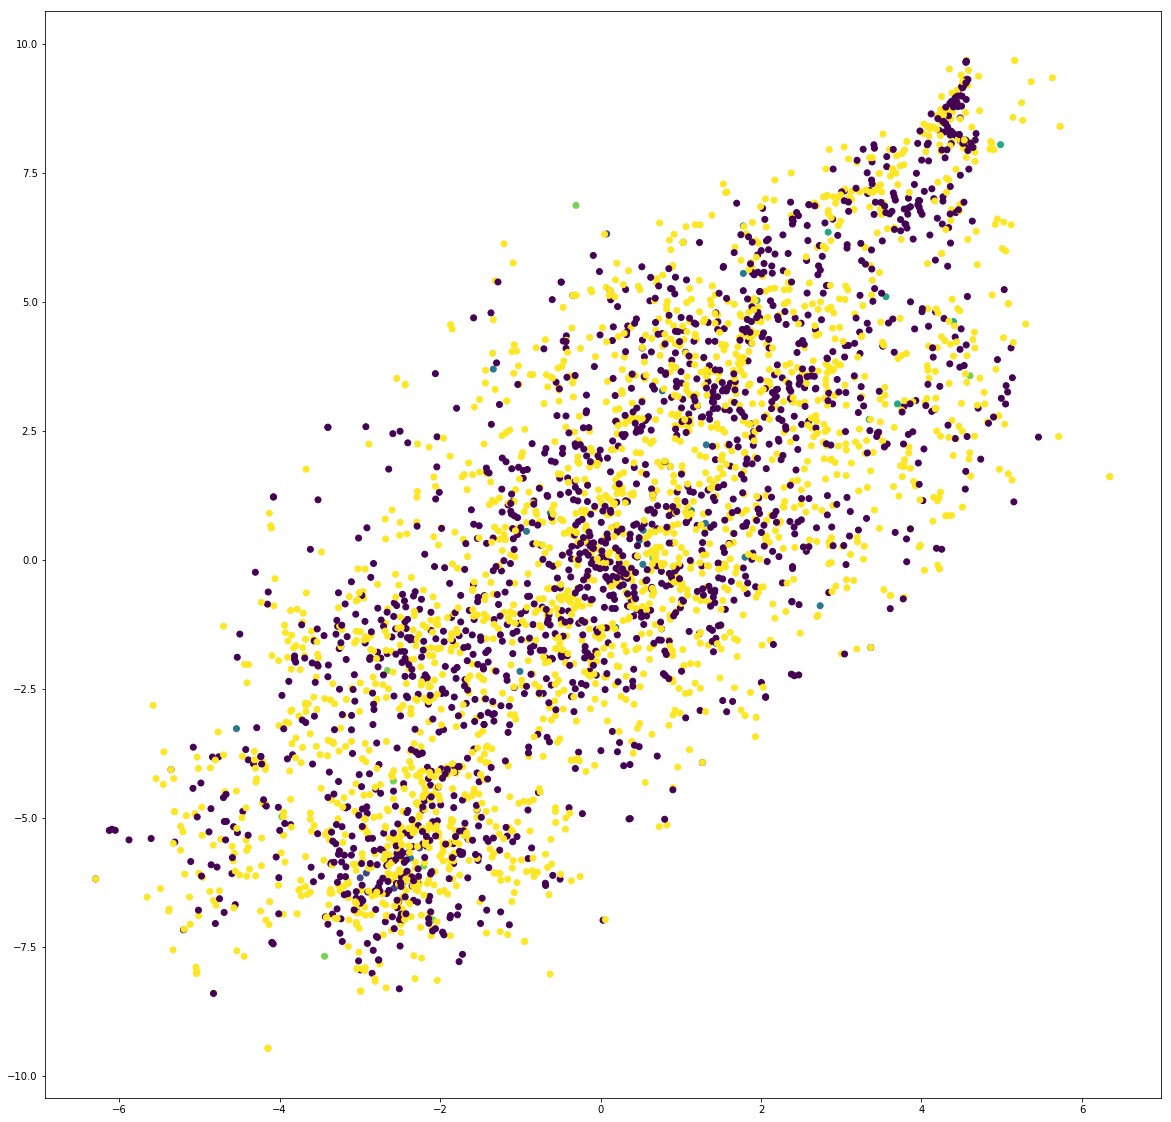

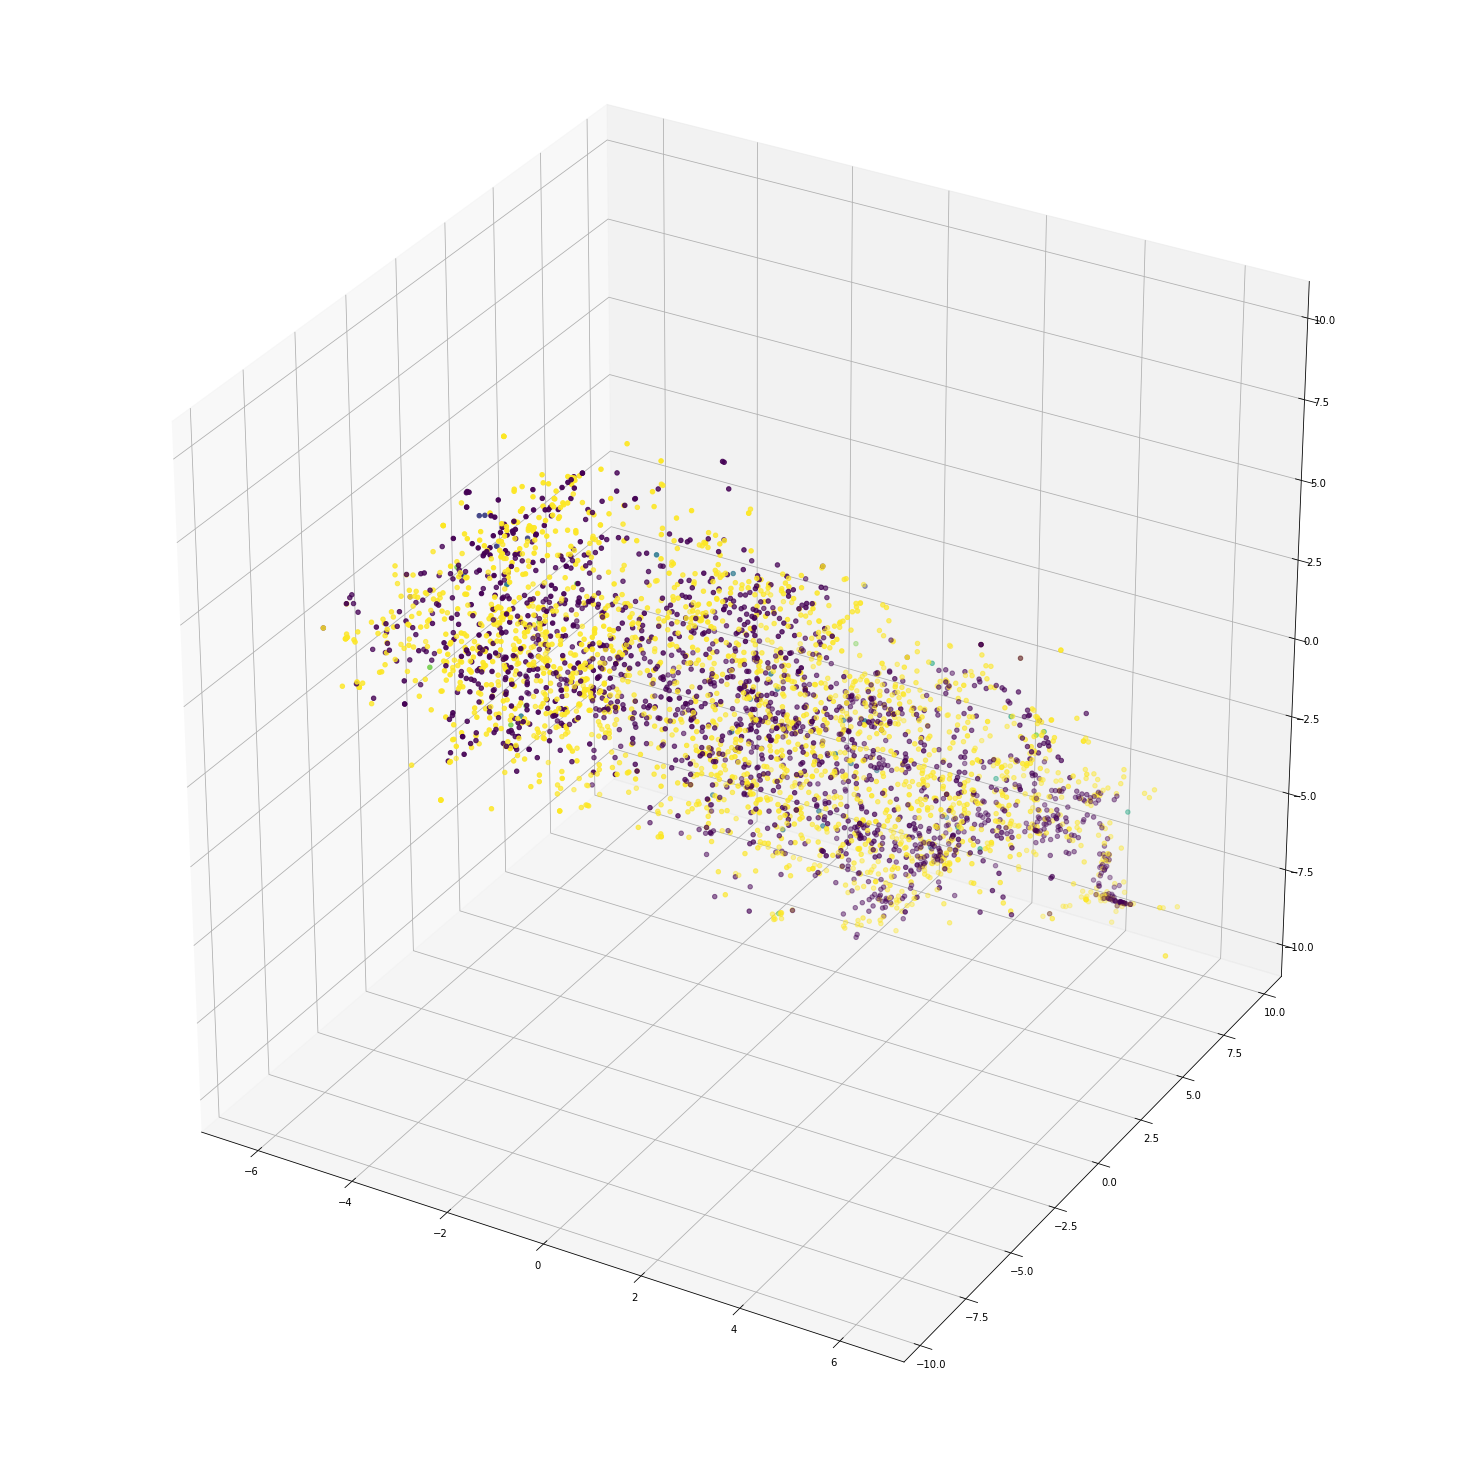

In [113]:
time_start = time.time()
tsne = TSNE(n_components = 3, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(gene_learned_encodings)
print("t-SNE Completed In : " + str(time.time() - time_start) + " seconds")

plt.figure(figsize= (20, 20))
plt.scatter(x = tsne_results[:, 0], y = tsne_results[:, 1], c = gene_label[:, 0])
plt.show()

fig = plt.figure(figsize = (20, 20))
ax = Axes3D(fig)

sequence_containing_x_vals = tsne_results[:, 0]
sequence_containing_y_vals = tsne_results[:, 1]
sequence_containing_z_vals = tsne_results[:, 2]


ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c = gene_label[:, 0])
plt.show()

In [3]:
str(subprocess.check_output('nvidia-smi', shell = True)).split('\\n')

["b'Fri Apr 24 14:20:35 2020       ",
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   73C    P0    30W /  70W |    193MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                        